In [1]:
import os
import glob
import itertools
import json
import cv2
import sys

import matplotlib as mpl
import scipy.stats as spstats
import pandas as pd
import numpy as np
import seaborn as sns
import pylab as pl
import statsmodels.api as sm
import pingouin as pg

In [2]:
import analyze2p.gratings.utils as gutils
import analyze2p.plotting as pplot
import analyze2p.aggregate_datasets as aggr
import analyze2p.utils as hutils
import analyze2p.receptive_fields.utils as rfutils
import analyze2p.extraction.rois as roiutils
import analyze2p.correlations as cr
import importlib


/n/coxfs01/2p-pipeline/envs/rat2p/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.10, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
%matplotlib notebook

In [4]:
#### Plotting params
visual_areas, area_colors = pplot.set_threecolor_palette()
pplot.set_plot_params(labelsize=6, lw_axes=0.25)
bw_colors = dict((v, [0.7]*3) for v in visual_areas)
#### Set trace ID and FOV/state type
aggregate_dir = '/n/coxfs01/julianarhee/aggregate-visual-areas'
rootdir='/n/coxfs01/2p-data'
traceid = 'traces001'
fov_type = 'zoom2p0x'
state = 'awake'

In [5]:
experiment = 'gratings'
responsive_test='ROC'
# ---------------------------------------------------------------
response_type='dff'
responsive_thr=0.05 if responsive_test=='ROC' else 10.0
n_stds=2.5
n_bootstrap_iters=500
print(responsive_test, responsive_thr)
#### Responsive params
ori_fit_desc = gutils.get_fit_desc(response_type=response_type, 
                            responsive_test=responsive_test, 
                            n_stds=n_stds, responsive_thr=responsive_thr, 
                            n_bootstrap_iters=n_bootstrap_iters) #, 
#                             n_resamples=n_resamples)
data_id = '|'.join([traceid, ori_fit_desc])
print(data_id)
#### Set current output dir
dst_dir = os.path.join(aggregate_dir, 'correlations', 
                       'gratings_%s_%s' % (response_type, responsive_test),
                       'pref_theta')
print(dst_dir)

ROC 0.05
traces001|fit-dff_responsive-ROC-thr0.05_boot-500
/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta


#### Metadata

In [6]:
sdata, cells0 = aggr.get_aggregate_info(visual_areas=visual_areas, return_cells=True)
meta = sdata[sdata.experiment.isin(['gratings'])].copy()
all_dkeys = [(va, dk) for (va, dk), g in meta.groupby(['visual_area', 'datakey'])]

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets


#### Trial responses

In [7]:
# Load trial metrics
trial_epoch='stimulus'
NDATA0 = aggr.load_responsive_neuraldata(experiment, traceid=traceid,
                      response_type=response_type, trial_epoch=trial_epoch,
                      responsive_test=responsive_test, 
                      responsive_thr=responsive_thr)
if experiment not in ['rfs', 'rfs10']: # assigned in load_responsive_neuraldata()
    NDATA0['experiment'] = experiment 
print("Stimulus: %s (cell counts)" % experiment)
print(NDATA0[['visual_area', 'datakey', 'cell']]\
        .drop_duplicates()['visual_area'].value_counts().to_markdown())
# Get the cells
CELLS = aggr.get_all_responsive_cells(cells0, NDATA0) 
print(CELLS[['visual_area', 'animalid', 'session', 'fovnum']]\
            .drop_duplicates()['visual_area'].value_counts().to_markdown())

/n/coxfs01/julianarhee/aggregate-visual-areas/dataset_info_assigned.pkl
Segmentation: missing 12 dsets
...loading: aggr_gratings_trialmeans_traces001_ROC-thr-0.05_dff_stimulus.pkl
Checking gratings configs
Stimulus: gratings (cell counts)
|    |   visual_area |
|:---|--------------:|
| V1 |           883 |
| Lm |           466 |
| Li |           431 |
|    |   visual_area |
|:---|--------------:|
| Li |            15 |
| Lm |             8 |
| V1 |             8 |


#### Tuning curve fits

In [38]:
gdata, missing_ = gutils.aggregate_ori_fits(CELLS, traceid=traceid, create_new=False,
                            fit_desc=ori_fit_desc, return_missing=True) 
gdata = hutils.split_datakey(gdata)
gdata['tf'] = gdata['sf']*gdata['speed'] # fit params
# Assign "preferred theta" for tested values
tested_thetas = np.arange(0, 360, 45)
theta_vals = np.arange(0, 360+45, 45)
gdata['tested_theta'] = [theta_vals[np.where(np.abs(t-theta_vals)==np.min(np.abs(t-theta_vals)))[0][0]] % 360. \
                            for t in gdata['theta_pref']]
gdata['tested_theta'] = gdata['tested_theta'].astype(float)
gdata['experiment'] = 'gratings'

#### Only take good fits

In [936]:
select_stimuli = 'all'
if select_stimuli=='FF':
    currg = gdata[(gdata['size']==200)].copy()#.reset_index(drop=True)
elif select_stimuli=='apertured':
    currg = gdata[(gdata['size']<200)].copy()#.reset_index(drop=True)
else: # all conds
    currg = gdata.copy()
    
best_gof_ixs = currg.groupby(['visual_area', 'datakey', 'cell'])['gof']\
                    .transform(max) == currg['gof']
assert currg.loc[best_gof_ixs].groupby(['visual_area', 'datakey', 'cell'])\
                    .count().max().max()==1
bestg = currg.loc[best_gof_ixs].copy()

In [937]:
# Unique datasets, get dsets with most ncells pass
min_ncells=0
gof_thr=0.5
drop_repeats=True

counts = aggr.count_n_cells(bestg[bestg['gof']>gof_thr], 
                            name='n_cells', reset_index=True)
print("All cells pass (GoF>%.2f)" % gof_thr)
print(counts.groupby('visual_area').sum().to_markdown())
# Drop duplicates
u_dkeys = aggr.drop_repeats(counts, colname='n_cells')   
FITS = pd.concat([g for (va, dk), g in bestg[bestg['gof']>gof_thr].groupby(['visual_area', 'datakey'])\
          if (va, dk) in u_dkeys])
ncells_fit = aggr.count_n_cells(FITS)
print("Unique datasets (pass, GoF>%.2f)" % gof_thr)
print(ncells_fit.groupby('visual_area').sum().to_markdown())

All cells pass (GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        90 |
| Lm            |       222 |
| V1            |       444 |
Unique datasets (pass, GoF>0.50)
| visual_area   |   n_cells |
|:--------------|----------:|
| Li            |        62 |
| Lm            |       214 |
| V1            |       444 |


In [938]:
# Drop same duplicates from trial responses
NDATA = pd.concat([g for (va, dk), g \
                   in NDATA0.groupby(['visual_area', 'datakey'])\
                   if (va, dk) in u_dkeys], ignore_index=True)
if 'experiment' not in NDATA.columns:
    NDATA['experiment'] = experiment
# Final counts
final_ncells = aggr.count_n_cells(NDATA)
final_totals = aggr.get_final_cell_and_site_counts(final_ncells)
print("FINAL totals: %s (%s)" % (experiment, responsive_test))
print(final_totals.to_markdown())

FINAL totals: gratings (ROC)
| visual_area   |   n_cells |   datakey |
|:--------------|----------:|----------:|
| Li            |       287 |        10 |
| Lm            |       455 |         7 |
| V1            |       883 |         8 |


<IPython.core.display.Javascript object>


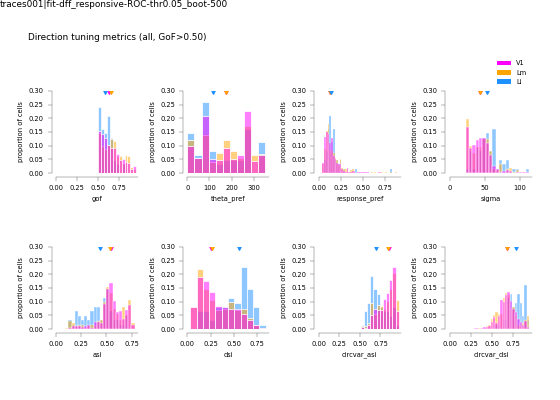

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta hist_per-area_metrics_gof0.50_all


gof                                                    \
             count      mean       std       min       25%       50%   
visual_area                                                            
Li            62.0  0.594653  0.071479  0.500778  0.535308  0.583824   
Lm           214.0  0.667581  0.114639  0.501177  0.571073  0.652739   
V1           444.0  0.651392  0.114105  0.500112  0.556456  0.626588   

                                theta_pref              ... circvar_asi  \
                  75%       max      count        mean  ...         75%   
visual_area                                             ...               
Li           0.633823  0.808742       62.0  153.337722  ...    0.786021   
Lm           0.747107  0.942944      214.0  173.202365  ...    0.903246   
V1           0.727974  0.948377      444.0  172.322118  ...    0.901431   

                      circvar_dsi                                          \
                  max       count      mean       std       min       25%   
visual_area                                                                 
Li           0.934026        62.0  0.778816  0.091882  0.515821  0.717339   
Lm           0.972189       214.0  0.677922  0.114507  0.358982  0.607158   
V1           0.970368       444.0  0.674461  0.106681  0.280241  0.616497   

                                           
                  50%       75%       max  
visual_area                                
Li           0.781053  0.850632  0.928063  
Lm           0.673924  0.744386  0.938331  
V1           0.679016  0.737777  0.916351  

[3 rows x 64 columns]

In [939]:
%matplotlib notebook
meds_= FITS.groupby('visual_area').median()
plot_params = ['gof', 'theta_pref',  'response_pref', 'sigma', 
               'asi', 'dsi', 'circvar_asi', 'circvar_dsi']

fig, axn = pl.subplots(2, int(len(plot_params)/2), figsize=(7,5),
                      sharey=False, dpi=100)
ylim=0.3
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=FITS, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(meds_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v', markersize=5)
    ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    #ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
leg_h = pplot.custom_legend_markers(colors=[area_colors[v] for v in visual_areas],
                                    labels=visual_areas, use_patch=True)
axn[0, 3].legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right', frameon=False)
pplot.adjust_subplots(bottom=0.15, right=0.95, wspace=0.6)
sns.despine(offset=4)
fig.text(0.05, 0.9,'Direction tuning metrics (%s, GoF>%.2f)'\
         % (select_stimuli, gof_thr), fontsize=8)

pplot.label_figure(fig, data_id)
figname = 'hist_per-area_metrics_gof%.2f_%s' % (gof_thr, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

FITS.groupby(['visual_area'])[plot_params].describe()

## Get RFs

In [940]:
response_type='dff'
do_spherical_correction=False
rf_fit_desc = rfutils.get_fit_desc(response_type=response_type,
                                  do_spherical_correction=do_spherical_correction)
rfdf = rfutils.aggregate_fits(cells0, sdata, combine='average', 
                              response_type=response_type,
                              do_spherical_correction=do_spherical_correction,
                              reliable_only=True,
                              pass_criterion='position')
rfdf = aggr.add_roi_positions(rfdf)

N dpaths: 56, N unfit: 0
N datasets included: 61, N sessions excluded: 4


In [941]:
import analyze2p.objects.sim_utils as su

print(rf_fit_desc)
try:
    rfpolys, _ = su.load_rfpolys(rf_fit_desc)
except FileNotFoundError as e:
    rfpolys, check_rfs = su.update_rfpolys(rfdf, rf_fit_desc, create_new=True)

fit-2dgaus_dff-no-cutoff


In [942]:
posdf_ = cr.get_roi_pos_and_rfs(bestg[bestg['gof']>gof_thr], curr_rfs=rfdf, 
                                 rfs_only=False, position_only=False,
                                 merge_cols=['visual_area', 'datakey', 'cell'])

In [943]:
fits_and_rfs = pd.merge(bestg[bestg['gof']>gof_thr], posdf_, on=['visual_area', 'datakey', 'cell'], 
                        how='outer')
fit_rfs_counts = aggr.count_n_cells(fits_and_rfs, split_na=True,
                                    suffix_a='all', suffix_b='rfs')
fit_rfs_counts.groupby('visual_area').sum()

,n_cells_all,n_cells_rfs
visual_area,,
Li,90,31.0
Lm,222,61.0
V1,444,220.0


# Tuning curves

In [944]:
curr_fits = FITS[(FITS.gof>0.5)].copy()
count_strong = aggr.count_n_cells(curr_fits)
count_strong.groupby('visual_area').sum()

,n_cells
visual_area,
Li,62
Lm,214
V1,444


In [945]:
dists = cr.aggregate_tuning_curve_ccdist(curr_fits, rfdf=rfdf, rfpolys=rfpolys, 
                                         min_ncells=3)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
    (20190522_JC089_fov1 NONE, skipping overlaps)
too few cells: Li, 20190617_JC099_fov1
    (20191018_JC113_fov1 NONE, skipping overlaps)
    (20191111_JC120_fov1 NONE, skipping overlaps)
    (20190306_JC061_fov2 NONE, skipping overlaps)
    (20190627_JC091_fov1 NONE, skipping overlaps)
[]


In [946]:
neg_corrs = dists[dists.pearsons<-0.8].copy()
neg_corrs

,xcorr,pearsons,cosim,cell_1,cell_2,neuron_pair,pref_dir_diff,pref_dir_diff_abs,pref_ori_diff,pref_ori_diff_abs,...,area_overlap,perc_overlap,rf_angle_diff,rf_angle_diff_abs,std_x,std_y,aspect_ratio,visual_area,datakey,n_cells
20,0.030950,-0.899226,0.613678,15,345,15_345,-176.326531,176.326531,3.673469,3.673469,...,0.456011,0.91459,-3.593607,3.593607,5.666605,8.287736,0.397737,Li,20190602_JC091_fov1,20
29,0.045342,-0.886142,0.415806,22,61,22_61,176.326531,176.326531,-3.673469,3.673469,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Li,20190602_JC091_fov1,20
38,0.066040,-0.977254,0.618914,22,345,22_345,-168.979592,168.979592,11.020408,11.020408,...,0.544111,0.817269,-4.161290,4.161290,2.512164,5.719374,0.317893,Li,20190602_JC091_fov1,20
86,0.031038,-0.820531,0.572413,37,345,37_345,-161.632653,161.632653,18.367347,18.367347,...,0.312888,0.746324,87.145243,87.145243,5.343848,9.537749,0.622786,Li,20190602_JC091_fov1,20
125,0.041633,-0.864251,0.609876,50,345,50_345,176.326531,176.326531,-3.673469,3.673469,...,0.082896,0.343918,38.147231,38.147231,12.079877,9.716887,0.026390,Li,20190602_JC091_fov1,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19258,0.029134,-0.893021,0.395710,211,335,211_335,88.163265,88.163265,88.163265,88.163265,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1,20191006_JC110_fov1,35
19280,0.026842,-0.804504,0.414776,228,384,228_384,88.163265,88.163265,88.163265,88.163265,...,0.522715,0.732258,-8.484148,8.484148,1.999894,0.204127,0.363126,V1,20191006_JC110_fov1,35
19307,0.032827,-0.806575,0.356880,276,384,276_384,80.816327,80.816327,80.816327,80.816327,...,0.62191,0.824773,-8.705701,8.705701,0.793860,1.451322,0.489279,V1,20191006_JC110_fov1,35
19360,0.024658,-0.829956,0.409805,338,359,338_359,-102.857143,102.857143,77.142857,77.142857,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,V1,20191006_JC110_fov1,35


In [947]:
for dk, nc in neg_corrs[(neg_corrs['visual_area']=='V1')].groupby('datakey'):
    check_cells = np.union1d(nc['cell_1'].unique(), nc['cell_2'].unique())
    fits_ = FITS[(FITS.visual_area=='V1') & (FITS.datakey==dk)
                & (FITS['cell'].isin(check_cells))].copy()
    fits_.index = fits_['cell'].values
    resp = fits_[(fits_['response_pref']>0.2) & (fits_.gof>=0.66)]
    print("%s: %i of %i responsive" % (dk, len(resp), len(fits_)))

20190511_JC083_fov1: 15 of 53 responsive
20190522_JC084_fov1: 10 of 49 responsive
20190613_JC097_fov1: 1 of 31 responsive
20190616_JC097_fov1: 5 of 61 responsive
20190617_JC097_fov1: 5 of 26 responsive
20190622_JC085_fov1: 19 of 68 responsive
20191006_JC110_fov1: 2 of 29 responsive


In [948]:
dists.columns

Index(['xcorr', 'pearsons', 'cosim', 'cell_1', 'cell_2', 'neuron_pair',
       'pref_dir_diff', 'pref_dir_diff_abs', 'pref_ori_diff',
       'pref_ori_diff_abs', 'sigma', 'response_pref', 'rf_distance', 'max_ecc',
       'min_ecc', 'cortical_distance', 'area_overlap', 'perc_overlap',
       'rf_angle_diff', 'rf_angle_diff_abs', 'std_x', 'std_y', 'aspect_ratio',
       'visual_area', 'datakey', 'n_cells'],
      dtype='object')

<IPython.core.display.Javascript object>


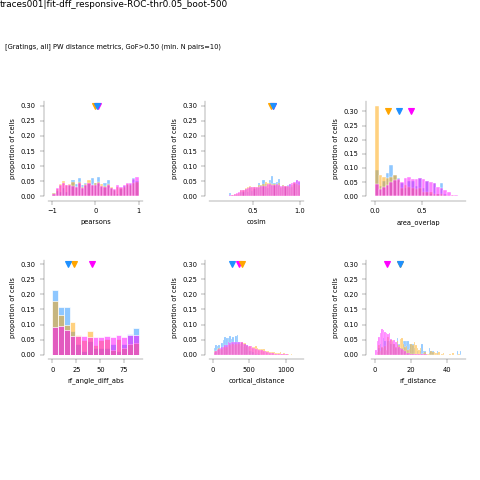

No handles with labels found to put in legend.


Text(0.01, 0.9, '[Gratings, all] PW distance metrics, GoF>0.50 (min. N pairs=10)')

In [951]:
%matplotlib notebook
plot_params = ['pearsons', 'cosim', 'area_overlap', 'rf_angle_diff_abs',
               'cortical_distance', 'rf_distance',
               'n_cells' ]
for p in plot_params:
    dists[p] = dists[p].astype(float)
means_= dists.groupby('visual_area').median()
means_

fig, axn = pl.subplots(2, int(len(plot_params)/2), figsize=(6,6))
ylim=0.3
for ax, par in zip(axn.flat, plot_params):
    sns.histplot(x=par, data=dists, ax=ax,
                 hue='visual_area', hue_order=visual_areas,palette=area_colors, 
                 stat='probability', common_norm=False, edgecolor='w')
    ax.legend_.remove()
    #ax.set_xlim([0, ax.get_xlim()[-1]])
    for va, vc in area_colors.items():
        m = float(means_.loc[va, par])
        ax.plot(m, ylim, color=vc, marker='v')
    #ax.set_ylim([0, ylim])
    ax.set_box_aspect(1)
    #ax.set_xlabel(name_lut[par])
    ax.set_ylabel('proportion of cells')
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=False)
pplot.adjust_subplots(bottom=0.25, right=0.97, wspace=0.7)
sns.despine(offset=4)

pplot.label_figure(fig, data_id)
figname = 'hist_distance_metrics_gof%.2f_%s' % (gof_thr, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))


fig.text(0.01, 0.9, '[Gratings, %s] PW distance metrics, GoF>%.2f (min. N pairs=%i)' \
             % (select_stimuli, gof_thr, min_npairs))

In [950]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta'

# Fit decay

In [952]:
df = dists.copy()
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=5
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

ang_step=5
ang_bins = np.arange(0, 90+ang_step, ang_step)
df = cr.cut_bins(df, ang_bins, 'rf_angle_diff_abs')

perc_step=0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step},
            'rf_angle_diff_abs': {'bins': ang_bins, 'step': ang_step}
           }

<IPython.core.display.Javascript object>


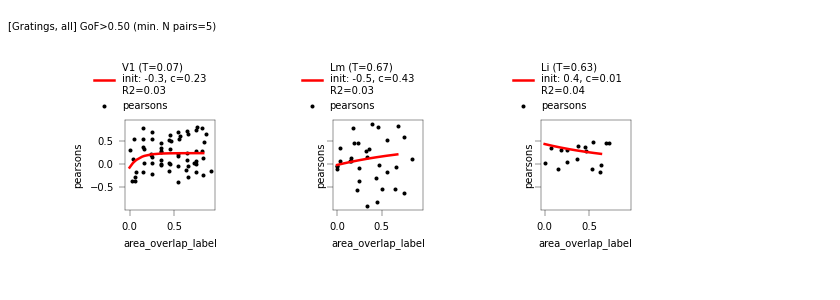

Text(0.01, 0.9, '[Gratings, all] GoF>0.50 (min. N pairs=5)')

In [954]:
%matplotlib notebook
metric='pearsons'
to_quartile = 'area_overlap'
x_var = '%s_label' % to_quartile

fit_sites = True
use_binned=False
min_npairs = 5
n_iter=int(np.random.rand(1)[0]*500)

cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
   
fig, axn = pl.subplots(1,3, figsize=(7,2.5), dpi=150, sharex=True, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>=min_npairs].index.tolist(),
                               cnts[cnts>=min_npairs].values))
    if len(nsamples_per)==0:
        ax.set_title(va)
        ax.set_box_aspect(1)
        continue
    # Sample
    cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                         for c, cg in cc0.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])
    # fov mean for visualizing
    if fit_sites:
        fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
    else:
        fit_cc = cc_.copy()
    # plot
    meas_cc = cc0.groupby(cnt_grouper).median().reset_index() #.dropna()
    ax.scatter(x=to_quartile, y=metric, data=meas_cc, s=2, color='k')
    res_, xvals, yvals = cr.fit_decay_on_binned(fit_cc, use_binned=use_binned,
                                            normalize_x=True, func='halflife',
                                            estimator='median',
                                            metric=metric,
                                            to_quartile=to_quartile,
                                            return_inputs=True)
    if all(res_.isnull()):
        print("BINNED, no fit: %s" % va)
        label='%s (no fit) ' % va
        fit_y = np.ones_like(xvals)*np.nan
    else:
        fit_y = cr.func_halflife(xvals, res_.init, res_.tau, res_.constant)
        label = '%s (T=%.2f)\ninit: %.1f, c=%.2f\nR2=%.2f' \
                        % (va, res_.tau, res_.init, res_.constant, res_.R2)
    ax.plot(xvals, fit_y, color='r', label=label)
    #ax.set_ylim([-0.2, 0.6])
    #ax.set_title(label, loc='left')
    ax.set_ylabel(metric)
    ax.set_xlabel(x_var)
    ax.legend(bbox_to_anchor=(1,1), loc='lower right', frameon=False, ncol=1)
    ax.set_box_aspect(1)
       #ax.set_title(va)
    #ax.set_xlim([0, 250])
   # ax.set_xlim([0, 40])
    #ax.set_ylim([0, 0.7])
pl.subplots_adjust(bottom=0.3, left=0.1, right=0.8, top=0.6)

fig.text(0.01, 0.9, '[Gratings, %s] GoF>%.2f (min. N pairs=%i)' \
             % (select_stimuli, gof_thr, min_npairs))

243


<IPython.core.display.Javascript object>


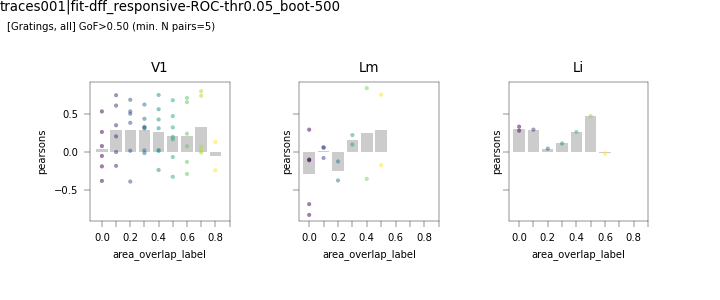

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta area_overlap_label_v_pearsons_barplot_byFOV_all


In [955]:
scale_ncells=False
plot_str='scale-ncells' if scale_ncells else ''

df = dists.copy().dropna(axis=0)
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 40+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

perc_step = 0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step},
            'rf_angle_diff_abs': {'bins': ang_bins, 'step': ang_step}
           }

# dist_var = 'rf_distance'
dist_var = to_quartile
x_var = '%s_label' % dist_var
max_dist = df[dist_var].max()
min_npairs=5
x_bins = [k for k in dist_lut[dist_var]['bins'] if k<=max_dist]

max_npairs = df.groupby(['visual_area', 'datakey', x_var])['neuron_pair'].count().max()
print(max_npairs)
fig, axn = pl.subplots(1,3, figsize=(6,2.5), dpi=150, sharex=False, sharey=True)
for va, cc0 in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
    cnts = cc0.groupby([x_var, 'datakey'])['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>=min_npairs].index.tolist(),
                               cnts[cnts>=min_npairs].values))
    if len(nsamples_per)==0:
        ax.set_title('%s (too few cells)' % va)
        ax.set_box_aspect(1)
        continue

    # Sample
    cc_ = pd.concat([cg for c, cg in cc0.groupby([x_var, 'datakey']) \
                         if c in nsamples_per.keys()])
    by_fov = cc_.groupby([x_var, 'datakey']).median().reset_index()
    # Get counts
    cnt_df = cnts.reset_index().rename(columns={'neuron_pair': 'n_pairs'})
    cnts_and_vals = pd.merge(cnt_df[cnt_df['n_pairs']>=min_npairs], by_fov, 
                        on=['%s_label' % dist_var, 'datakey'], how='outer')
    sns.barplot(x=x_var, y=metric, data=cnts_and_vals, ax=ax, ci=None, 
               color=[0.8]*3, zorder=-10000)
#     sns.stripplot(x=x_var, y=metric, data=by_fov, ax=ax, size=3,
#                  palette='viridis', hue=x_var, jitter=False)
    cnts_and_vals['%s_ix' % x_var] = [x_bins.index(i) for i in cnts_and_vals[x_var]]
    if scale_ncells:
        sns.scatterplot(x='%s_ix' % x_var, y=metric, data=cnts_and_vals, ax=ax,
                     palette='viridis', hue=x_var, size='n_pairs',
                     sizes=(min_npairs, max_npairs), alpha=0.5,
                     size_norm=(min_npairs, max_npairs), edgecolor=None)
    else:
        sns.scatterplot(x='%s_ix' % x_var, y=metric, data=cnts_and_vals, ax=ax,
                 palette='viridis', hue=x_var, alpha=0.5, s=5, edgecolor=None) 
    ax.legend_.remove()
    ax.set_box_aspect(1)
    ax.set_title(va)
    ax.set_xticks(np.arange(0, len(x_bins)))
    if dist_var=='area_overlap':
        ax.set_xticklabels([round(i, 1) if i in x_bins[0::2] else '' for i in x_bins])
    else:
        ax.set_xticklabels([int(i) if i in x_bins[0::2] else '' for i in x_bins])
pl.subplots_adjust(wspace=0.5)
fig.text(0.01, 0.9, '[Gratings, %s] GoF>%.2f (min. N pairs=%i)' 
         % (select_stimuli, gof_thr, min_npairs))

pplot.label_figure(fig, data_id)
figname = '%s_v_%s_barplot_byFOV_%s%s' % (x_var, metric, select_stimuli,plot_str)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


# Bootstrap

In [956]:
dists['rf_distance'].max()

47.71563979448195

In [957]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [958]:
df = dists.copy()
# Split distances into X um bins
ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2.5
rf_bins = np.arange(0, 50+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')
df.head()

perc_step = 0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

In [959]:
use_binned = False # Average the values in each bin, then fit.
fit_sites = True # Only average within-animal
use_quartile=False
metric='pearsons'
to_quartile='area_overlap'
# --------------------------------------------------
if metric in ['rf_angle_diff', 'pref_dir_diff_abs', 'pref_ori_diff_abs']:
    ymax = 180 if metric=='pref_dir_diff_abs' else 90
else:
    ymax=None
    
cut_str = 'qcut' if use_quartile else 'cut'
bin_str = 'fitbin' if use_binned else 'fitraw'
fit_str = 'avgfov' if fit_sites else 'cellpairs' 
bin_type = '%s-%s-%s' % (cut_str, bin_str, fit_str)
print('Fitting: %s' % bin_type)
n_iterations=500
# Fit function
resdf = cr.bootstrap_fitdecay(df.dropna(), use_binned=use_binned, 
                         fit_sites=fit_sites,
                         metric=metric, to_quartile=to_quartile,
                         bin_column='bin_value', normalize_x=True, ymax=ymax,
                         n_iterations=n_iterations)
for p in ['R2', 'init', 'tau', 'constant']:
    resdf[p] = resdf[p].astype(float)
print(resdf[resdf['R2']>0.5].shape)

Fitting: cut-fitraw-avgfov
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    val out of bounds
    v

In [960]:
vmin = -1 if ymax is None else 0
vmax = 1 if ymax is None else ymax
print(vmin, vmax)
print("init: %i/%i iters too big" % (resdf[resdf.init>vmax].shape[0], n_iterations))
print("init: %i/%i iters too small" % (resdf[resdf.init<=vmin].shape[0], n_iterations))

print("tau: %i/%i iters too big" % (resdf[resdf.tau>200].shape[0], n_iterations))
print("tau: %i/%i iters too small" % (resdf[resdf.init<=0].shape[0], n_iterations))

-1 1
init: 74/500 iters too big
init: 19/500 iters too small
tau: 0/500 iters too big
tau: 708/500 iters too small


In [961]:
importlib.reload(cr)

<module 'analyze2p.correlations' from '/net/coxfs01/srv/export/coxfs01/share_root/2p-pipeline/repos/rat-2p-area-characterizations/analyze2p/correlations.py'>

In [962]:
resdf = resdf[resdf.replace([np.inf, -np.inf], np.nan).notnull().all(axis=1)]

if use_binned:
    print("is binned, checking R2")
    finalres = resdf[(resdf['init']<=1.2) & (resdf['init']>=-1.2) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)
                   & (resdf['R2']>0.5)].copy().dropna()
else:
    finalres = resdf[(resdf['init']<=1) & (resdf['init']>=-1) 
                   & (resdf['tau']<=2000) & (resdf['tau']>=0)].copy().dropna()
                   #& (resdf['R2']>0.5)].copy()
print(resdf.shape, finalres.shape)

(1244, 6) (1155, 6)


RF overlap (%)


<IPython.core.display.Javascript object>


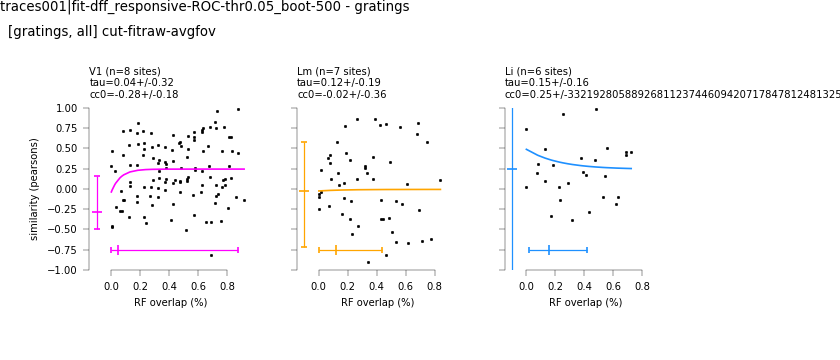

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta area_overlap_curves_v_pearsons_all


In [963]:
if to_quartile=='area_overlap':
    x_pos = -0.1
    xlabel='RF overlap (%)'
else:
    x_pos = -100 if to_quartile=='cortical_distance' else -10
    xlabel='cortical distance (um)' if to_quartile=='cortical_distance' \
            else 'RF distance (deg)'

ylabel='similarity (%s)' % metric
print(xlabel)
use_best_r2=False
fig = cr.plot_fit_distance_curves(df, resdf.dropna(),  metric=metric, 
                            to_quartile=to_quartile, 
                            use_best_r2=use_best_r2, fit_sites=fit_sites,
                            area_colors=area_colors, 
                            x_pos=x_pos, y_pos=-0.75,elinewidth=0.75,
                            ylim=(-1, 1), xlabel=xlabel, ylabel=ylabel)
fig.text(0.01, 0.9, '[%s, %s] %s' \
             % (experiment, select_stimuli, bin_type), fontsize=8)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
figname = '%s_curves_v_%s_%s' % (to_quartile, metric, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


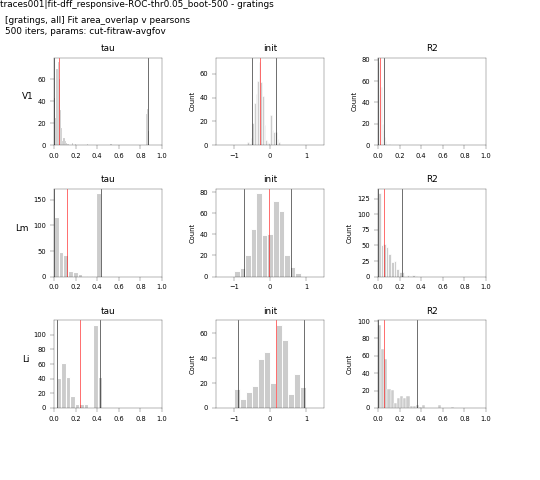

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta param_distns_area_overlap_v_pearsons_all


In [965]:
tau_lim=1200 if to_quartile=='cortical_distance' else 80
tau_lim = 1
fig, axn = pl.subplots(3,3, figsize=(6.75,6))
for va, rd_ in finalres.groupby('visual_area'):
    for pi, param in enumerate(['tau', 'init', 'R2']):
        ax=axn[visual_areas.index(va), pi]
        sns.histplot(x=param, data=rd_, ax=ax, color=[0.8]*3, 
                    edgecolor='w', stat='count', alpha=1)
        ci_lo, ci_hi = hutils.get_empirical_ci(rd_[param].values)
        ax.axvline(x=ci_lo, color='k', lw=0.5)
        ax.axvline(x=ci_hi, color='k', lw=0.5)
        med = rd_[param].median()
        ax.axvline(x=med, color='r', lw=0.5)
        ax.set_title(param)
        ax.set_xlabel('')
        if param=='tau':
            ax.set_xlim([0, tau_lim])
        elif param=='init':
            ax.set_xlim([-1.5, 1.5])
        elif param=='R2':
            ax.set_xlim([0, 1])
    axn[visual_areas.index(va), 0].set_ylabel(va, fontsize=8, rotation=0, ha='right')
    
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, hspace=0.5, wspace=0.5)

pplot.label_figure(fig, '%s - %s' % (data_id, experiment))
fig.text(0.01, 0.93, "[%s, %s] Fit %s v %s\n%i iters, params: %s" 
    % (experiment, select_stimuli, to_quartile, metric, n_iterations, bin_type), 
         fontsize=8)

figname = 'param_distns_%s_v_%s_%s' % (to_quartile, metric, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)


## Lin fit?

In [966]:
df = dists.copy()
# Split distances into X um bins
ctx_step=25
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

ang_step=5
ang_bins = np.arange(0, 90+ang_step, ang_step)
df = cr.cut_bins(df, ang_bins, 'rf_angle_diff_abs')

perc_step=0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step},
            'rf_angle_diff_abs': {'bins': ang_bins, 'step': ang_step}
           }

<IPython.core.display.Javascript object>


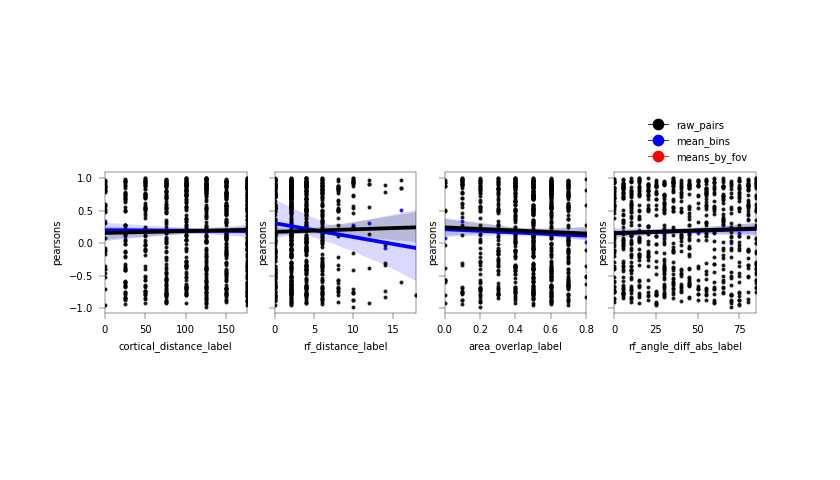

cortical_distance: r=0.02, p=0.49
rf_distance: r=0.02, p=0.59
area_overlap: r=-0.04, p=0.32
rf_angle_diff_abs: r=0.04, p=0.27


In [967]:
vg = df[(df.visual_area==va) & (df.cortical_distance<=200)].copy().dropna()

dist_list=['cortical_distance', 'rf_distance', 'area_overlap', 'rf_angle_diff_abs']
metric='pearsons'
fig, axn = pl.subplots(1, 4, figsize=(7,4), dpi=150, sharey=True)
for ax, to_quartile in zip(axn.flat, dist_list):
    # plot
    x_var = '%s_label' % to_quartile
    means = vg.groupby([x_var]).mean().reset_index()
    
    sns.regplot(x=x_var, y=metric, data=means,  ax=ax,
                color='b', scatter_kws={'s':2}, scatter=True)
    sns.regplot(x=x_var, y=metric, data=vg,  ax=ax, 
                color='k', scatter_kws={'s':2}, scatter=True)
#     fov_means = means = vg.groupby(['datakey', x_var]).median().reset_index()
#     sns.regplot(x=x_var, y=metric, data=fov_means,  ax=ax, 
#                 color='r', scatter_kws={'s':2}, scatter=False)
    
    ax.set_box_aspect(1)
    r, p = spstats.pearsonr(vg[to_quartile], vg[metric])
    print('%s: r=%.2f, p=%.2f' % (to_quartile, r, p))
    
leg_h = pplot.custom_legend_markers(colors=['k', 'b', 'r'],
                                           labels=['raw_pairs', 'mean_bins',
                                                  'means_by_fov'])
ax.legend(handles=leg_h, bbox_to_anchor=(1,1), loc='lower right', frameon=False)

In [969]:
cnt_grouper

['area_overlap_label', 'datakey']

<IPython.core.display.Javascript object>


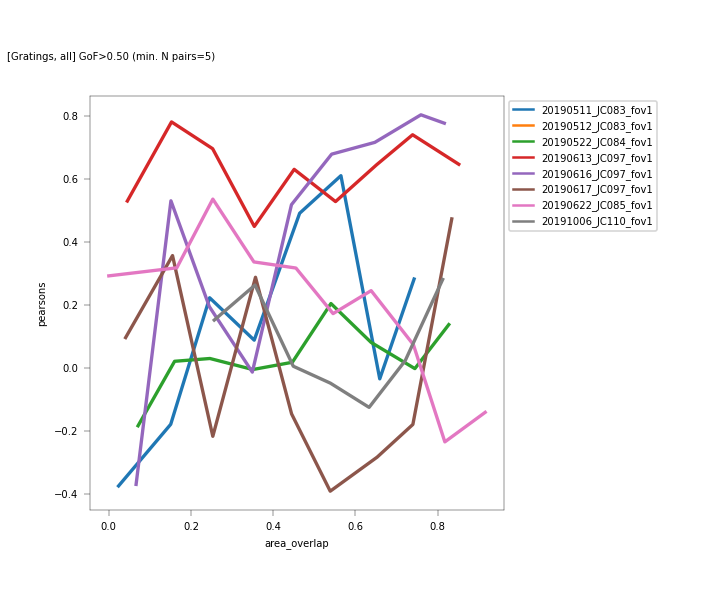

Text(0.01, 0.9, '[Gratings, all] GoF>0.50 (min. N pairs=5)')

In [970]:
y_var='pearsons'
dist_var = 'area_overlap'
x_var = '%s_label' % dist_var
cnt_grouper = [x_var] 
if fit_sites:
    cnt_grouper.append('datakey')
    
fig, ax = pl.subplots(figsize=(6,5), dpi=150)
cc0 = df[df.visual_area=='V1'].copy()

cnts = cc0.groupby(cnt_grouper)['neuron_pair'].count()  
# How many resample per group
nsamples_per = dict((k, v) for k, v \
                    in zip(cnts[cnts>min_npairs].index.tolist(),
                           cnts[cnts>min_npairs].values))
# Sample
cc_ = pd.concat([cg.sample(nsamples_per[c], random_state=n_iter, replace=True) \
                     for c, cg in cc0.groupby(cnt_grouper) \
                     if c in nsamples_per.keys()])
# fov mean for visualizing
if fit_sites:
    fit_cc = cc_.groupby(cnt_grouper).median().reset_index().dropna()
else:
    fit_cc = cc_.copy()
ax.set_box_aspect(1)
# plot
meas_cc = cc0.groupby(cnt_grouper).median().reset_index().dropna()
sns.lineplot(x=dist_var, y=y_var, data=meas_cc, hue='datakey', ax=ax,
            linewidth=2)
#ax.legend_.remove()
ax.legend(bbox_to_anchor=(1,1), loc='upper left', frameon=True)
pl.subplots_adjust(right=0.7)

fig.text(0.01, 0.9, '[Gratings, %s] GoF>%.2f (min. N pairs=%i)' 
         % (select_stimuli, gof_thr, min_npairs))



<IPython.core.display.Javascript object>


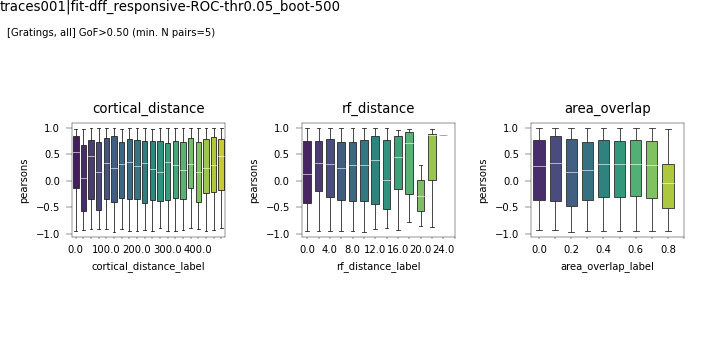

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta box_pearsons_v_dist-metrics_all


In [971]:
va='V1'
# Split distances into X um bins
ctx_step=25
ctx_maxdist = 500
df = dists[(dists.cortical_distance<=ctx_maxdist) 
          & (dists.visual_area==va)].copy()

ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

ang_step=5
ang_bins = np.arange(0, 90+ang_step, ang_step)
df = cr.cut_bins(df, ang_bins, 'rf_angle_diff_abs')

perc_step=0.1
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step},
            'rf_angle_diff_abs': {'bins': ang_bins, 'step': ang_step}
           }

y_var = 'pearsons'
fig, axn = pl.subplots(1,3, figsize=(6,3), dpi=150)
for ax, dist_var in zip(axn.flat, ['cortical_distance', 'rf_distance', 'area_overlap']):
    if dist_var=='area_overlap':
        curr_maxdist=1
    else:
        curr_maxdist = min([30, df['%s_label' % dist_var].max()]) \
                                if dist_var=='rf_distance' else ctx_maxdist
    ax.set_title(dist_var)
    x_var = '%s_label' % dist_var
    sorted_x_vars = [k for k, v in df.groupby(x_var) if k<=curr_maxdist]
    df_ = df[df[dist_var]<=curr_maxdist]
    cnts = df_.groupby(cnt_grouper)['neuron_pair'].count()  
    # How many resample per group
    nsamples_per = dict((k, v) for k, v \
                        in zip(cnts[cnts>=min_npairs].index.tolist(),
                               cnts[cnts>=min_npairs].values))
    # Sample
    cc_ = pd.concat([cg for c, cg in df_.groupby(cnt_grouper) \
                         if c in nsamples_per.keys()])

    sns.boxplot(x=x_var, y=y_var, ax=ax, data=cc_,
                hue=x_var, palette='viridis',
               dodge=False, width=0.7, fliersize=0, linewidth=0.5,
               medianprops=dict(color='w', alpha=0.7)) #color=[0.8]*3)

    
#     sns.stripplot(x=x_var, y=y_var, ax=ax, data=df,
#                   size=2, color='k')
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=1)
    ax.set_xticks(np.arange(0, len(sorted_x_vars)))
    xlabel_step = 4 if dist_var=='cortical_distance' else 2
    ax.set_xticklabels([round(i, 1) if i in sorted_x_vars[0::xlabel_step] else ''\
                        for i in sorted_x_vars])
    ax.set_box_aspect(0.75)

pl.subplots_adjust(left=0.1, right=0.95, wspace=0.5, bottom=0.2, top=0.8)
fig.text(0.01, 0.9, '[Gratings, %s] GoF>%.2f (min. N pairs=%i)' 
         % (select_stimuli, gof_thr, min_npairs))

pplot.label_figure(fig, data_id)
figname = 'box_%s_v_dist-metrics_%s' % (y_var, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [972]:
len(vg['cortical_distance_label'].unique())

8

['area_overlap_label', 'datakey']
0.9295474886894226 1.9120718897092104e-10
0.9383854866027832 5.4711385730037325e-21


<IPython.core.display.Javascript object>


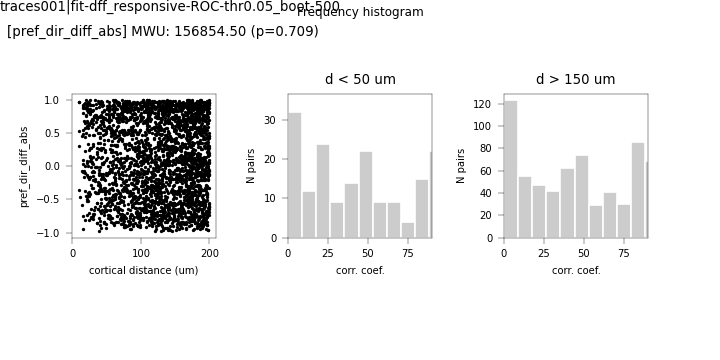

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_dir_diff_abs_v_ctx-near_cts-far_all


In [973]:
y_var='pref_dir_diff_abs'
xlim = [0, 90]
nbins=20

va='V1'

#col1='blue'
#col2='purple'
# col1=grp_colors[0]
# col2=grp_colors[25]
print(cnt_grouper)

cc_ = dists[(dists.visual_area==va) & (dists.cortical_distance<=200)].copy()

col_list = sns.color_palette('viridis', 
                             n_colors=8)
col1 = [0.8]*3 #col_list[0]
col2 = [0.8]*3 #col_list[1]
near_lim = 50
# v1 = vg[(vg.distance_group_label==0)][y_var].values
# v2 = vg[(vg.distance_group_label==100)][y_var].values
v1 = cc_[(cc_.cortical_distance<50)][y_var].values
#v2 = vg[(vg.cortical_distance_label.isin([near_lim, 75]))][y_var].values
v2 = cc_[(cc_.cortical_distance>150)][y_var].values

# testd = pd.DataFrame({'v1': v1, 'v2': v2})
w, pvalue = spstats.shapiro(v1)
print(w, pvalue)
w, pvalue = spstats.shapiro(v2)
print(w, pvalue)

fig, axn = pl.subplots(1, 3, sharex=False, sharey=False,dpi=150, figsize=(6,3))
fig.suptitle('Frequency histogram')

ax=axn[0]
ax.scatter(x='cortical_distance', y='pearsons', data=cc_, #ax=ax, 
          s=1, color='k')
ax.set_ylabel(y_var)
ax.set_xlabel('cortical distance (um)')
ax=axn[1]
ax.hist(v1, bins=nbins, histtype='bar', ec='k', color=col1, edgecolor='w')
ax.set_title('d < %i um' % near_lim)
ax.set_ylabel("N pairs")
ax.set_xlim(xlim)
ax.set_xlabel('corr. coef.')

ax=axn[2]
ax.hist(v2, bins=nbins, histtype='bar', ec='k', color=col2, edgecolor='w')
#ax.set_title('%i um < d < %i um' % (near_lim, 100))
ax.set_title('d > %i um' % (150)) #, 100))
ax.set_ylabel("N pairs")
ax.set_xlim(xlim)
ax.set_xlabel('corr. coef.')

# wts1 = np.ones_like(v1)/len(v1)
# ax3.hist(v1, bins=10, histtype='step', ec=col1, cumulative=True, weights=wts1, lw=1)
# wts2 = np.ones_like(v2)/len(v2)
# ax3.hist(v2, bins=10, histtype='step', ec=col2, cumulative=True,
#         weights=wts2, lw=1)
# for ax in fig.axes:
#     ax.set_xlabel(y_var)

for ax in fig.axes:
    ax.set_box_aspect(1)
U, p = spstats.mannwhitneyu(x=v1, y=v2, alternative = 'two-sided')
fig.text(0.01, 0.9, '[%s] MWU: %.2f (p=%.3f)' % (y_var, U, p),fontsize=8)
pl.subplots_adjust(wspace=0.5, left=0.1, right=0.9, bottom=0.2)


pplot.label_figure(fig, data_id)
figname = '%s_v_ctx-near_cts-far_%s' % (y_var, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [974]:
# Split distances into X um bins
ctx_step=20
ctx_maxdist = 500
df = dists[dists.cortical_distance<=ctx_maxdist].copy()

ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

rf_step=2
rf_bins = np.arange(0, 60+rf_step, rf_step)
df = cr.cut_bins(df, rf_bins, 'rf_distance')

ang_step=5
ang_bins = np.arange(0, 90+ang_step, ang_step)
df = cr.cut_bins(df, ang_bins, 'rf_angle_diff_abs')

perc_step=0.05
perc_bins = np.arange(0, 1+perc_step, perc_step)
df = cr.cut_bins(df, perc_bins, 'area_overlap')

dist_lut = {'cortical_distance': {'bins': ctx_bins, 'step': ctx_step},
            'rf_distance': {'bins': rf_bins, 'step': rf_step},
            'area_overlap': {'bins': perc_bins, 'step': perc_step},
            'rf_angle_diff_abs': {'bins': ang_bins, 'step': ang_step}
           }


<IPython.core.display.Javascript object>


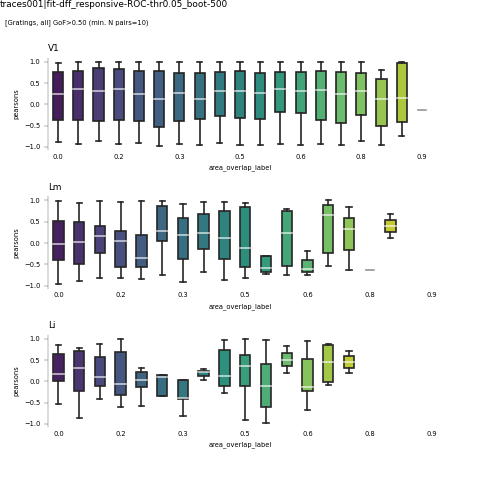

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta box_pearsons_v_bin-area_overlap_all


In [975]:
y_var = 'pearsons'
dist_var = 'area_overlap'
x_var = '%s_label' % dist_var
# Ticks
min_npairs=10 #10
max_dist = ctx_maxdist

sorted_x_vars = [k for k, v in df.groupby(x_var) if k<=max_dist]

fig, axn = pl.subplots(3, 1, figsize=(6,6))
for va, vg in df.groupby('visual_area'):
    ax=axn[visual_areas.index(va)]
#     sns.barplot(x='binned_cortical_distance', y=y_var, ax=ax, data=vg,
#                 color=[0.8]*3, dodge=False, estimator=np.median, errwidth=0.5)
#     sns.stripplot(x='binned_cortical_distance', y=y_var, ax=ax, data=vg,
#                   hue='cortical_distance_label', dodge=False, size=2, 
#                   palette='viridis')
#     ax.legend(bbox_to_anchor=(1,1), loc='upper left', markerscale=0.5)
    sns.boxplot(x=x_var, y=y_var, ax=ax, data=vg,
                hue=x_var, palette='viridis',
               dodge=False, width=0.5, fliersize=0,
               medianprops=dict(color='w', alpha=0.7)) #color=[0.8]*3)
#     sns.stripplot(x=x_var, y=y_var, ax=ax, data=vg,
#                   size=2, color='k')
    ax.legend_.remove()
    ax.tick_params(which='both', axis='x', size=0)
    ax.set_xticks(np.arange(0, len(sorted_x_vars)))
    ax.set_xticklabels([round(i,1) if i in sorted_x_vars[0::3] else ''\
                        for i in sorted_x_vars])
    ax.set_title(va, loc='left', fontsize=8)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.11, hspace=0.5)
fig.text(0.01, 0.95, '[Gratings, %s] GoF>%.2f (min. N pairs=%i)' 
         % (select_stimuli, gof_thr, min_npairs))



sns.despine(bottom=True)
pplot.label_figure(fig, data_id)
figname = 'box_%s_v_bin-%s_%s' % (y_var, dist_var, select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [976]:
vg['cortical_distance_label'].unique()

array([160., 180., 140., 300., 260., 360., 380., 420., 400., 220., 280.,
       200., 340., 480., 440., 460.,  60.,  40., 320., 240., 100., 120.,
        20.,  80.,   0.])

In [977]:
va= 'V1'
ctx_maxdist=800
ctx_step = 50
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = dists[(dists.cortical_distance<=ctx_maxdist)
             & (dists.visual_area==va)].copy().dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.05
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')

<IPython.core.display.Javascript object>


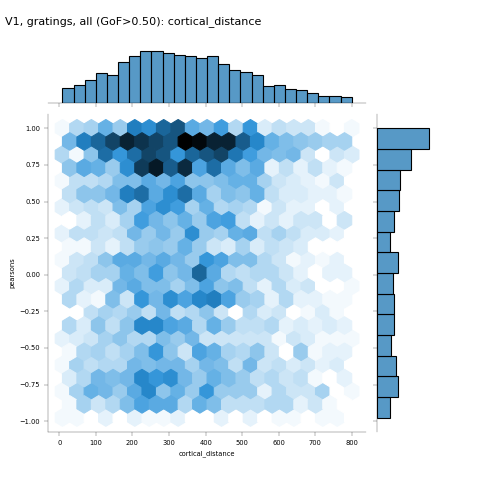

<IPython.core.display.Javascript object>


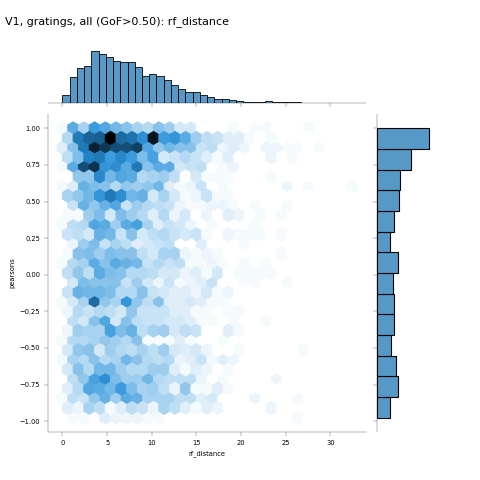

<IPython.core.display.Javascript object>


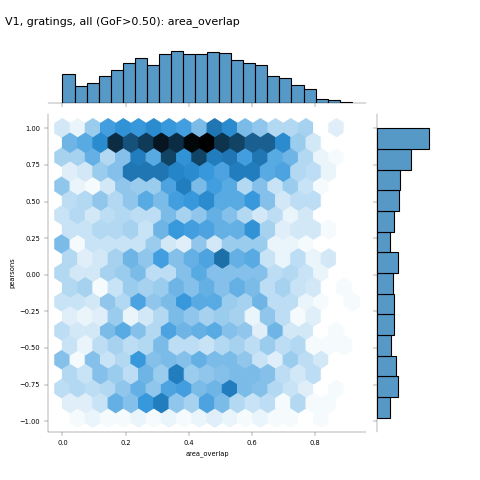

In [978]:
%matplotlib notebook


# dk='20190616_JC097_fov1'
# df_=plotd[plotd.datakey==dk]

#fig, ax = pl.subplots(figsize=(5,5), dpi=150)

# ax = cr.heatmap_tuning_v_distance(df_, x_bins, y_bins, ax=ax,
#                                   x_var=x_var, y_var=y_var, 
#                                   hue_var=hue_var, hue_norm=(-0.8, 0.8),
#                                   cmap=cmap, cbar=False)
y_var='pearsons'
for dist_var in ['cortical_distance', 'rf_distance', 'area_overlap']:
    fg = sns.jointplot(x=dist_var, y=y_var, data=plotd, 
                    kind='hex', height=6, )
    pl.subplots_adjust(left=0.1, bottom=0.1, top=0.9, right=0.9)
    fg.fig.text(0.01, 0.95, '%s, gratings, %s (GoF>%.2f): %s' \
                % (va, select_stimuli, gof_thr, dist_var),
               fontsize=10)
    
    figname = 'joint_%s_and_%s_V1' % (y_var, dist_var)
    pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))

In [925]:
dst_dir

'/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta'

In [979]:
x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons'

grped_means = plotd.groupby(['%s_label' % x_var, '%s_label' % y_var]).mean()
grped_means[hue_var].min().min(), grped_means[hue_var].max().max()

(-0.9368160341728494, 0.988765545882179)

In [980]:
0.6430036281289704, 0.9922229158296262

(0.6430036281289704, 0.9922229158296262)

In [984]:
len(plotd['datakey'].unique())


15

<IPython.core.display.Javascript object>


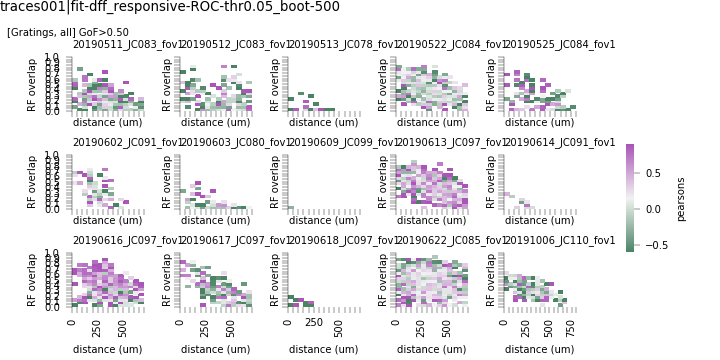

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta V1_heatmaps_byFOV_RFsimilarity_CXdist_tuning_all


In [985]:
nr=3
nc=5


x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons'
hue_min, hue_max = (-0.6, 0.9)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

fig, axn = pl.subplots(nr, nc, figsize=(6, 3), dpi=150, sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.87, 0.3, 0.01, 0.3])
for ai, (ax, (dk, df_)) in enumerate(zip(axn.flat, plotd.groupby('datakey'))):

    cnts = df_.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=1][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=1][y_var_name].unique()
    df0 = df_[(df_[x_var_name].isin(valid_x)) & (df_[y_var_name].isin(valid_y))]

    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                  x_var=x_var, y_var=y_var, 
                                  hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                  cmap=cmap, cbar=ai==0, 
                                    cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(dk, loc='left', fontsize=6)
    ax.set_ylabel('RF overlap')
    ax.set_xlabel('distance (um)')

fig.text(0.01, 0.9, '[Gratings, %s] GoF>%.2f' 
         % (select_stimuli, gof_thr))
pl.subplots_adjust(wspace=0.5, right=0.8, left=0.1)

sns.despine(bottom=True)
pplot.label_figure(fig, data_id)
figname = 'V1_heatmaps_byFOV_RFsimilarity_CXdist_tuning_%s' % ( select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

<IPython.core.display.Javascript object>


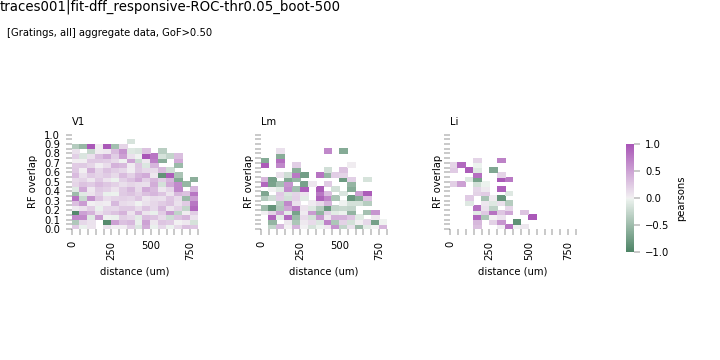

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta all_heatmaps_byFOV_RFsimilarity_CXdist_tuning_all


In [983]:
ctx_maxdist=800
ctx_step = 50
ctx_bins = np.arange(0, ctx_maxdist+ctx_step, ctx_step)

plotd = dists[(dists.cortical_distance<=ctx_maxdist)].copy().dropna()
plotd = cr.cut_bins(plotd, ctx_bins, 'cortical_distance')

perc_max=1
perc_step=0.05
perc_bins = np.arange(0, perc_max+perc_step, perc_step)
plotd = cr.cut_bins(plotd, perc_bins, 'area_overlap')

rf_maxdist = 60
rf_step = 2
rf_bins = np.arange(0, rf_maxdist+rf_step, rf_step)
plotd = cr.cut_bins(plotd, rf_bins, 'rf_distance')
# -----------------------------
x_bins = ctx_bins.copy()
y_bins = perc_bins.copy()
x_var = 'cortical_distance'
y_var = 'area_overlap'
hue_var = 'pearsons'
hue_min, hue_max = (-1, 1)
cmap=sns.diverging_palette(145, 300, s=60, as_cmap=True)
x_var_name = '%s_label' % x_var
y_var_name = '%s_label' % y_var

fig, axn = pl.subplots(1, 3, figsize=(6, 3), dpi=150, sharex=True, sharey=True)
cbar_ax = fig.add_axes([0.87, 0.3, 0.01, 0.3])
for ai, (va, df_) in enumerate(plotd.groupby('visual_area')):
    ax=axn[visual_areas.index(va)]
    cnts = df_.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
    valid_x = cnts[cnts['neuron_pair']>=1][x_var_name].unique()
    valid_y = cnts[cnts['neuron_pair']>=1][y_var_name].unique()
    df0 = df_[(df_[x_var_name].isin(valid_x)) & (df_[y_var_name].isin(valid_y))]

    ax=cr.heatmap_tuning_v_distance(df0, x_bins, y_bins, ax=ax,
                                  x_var=x_var, y_var=y_var, 
                                  hue_var=hue_var, hue_norm=(hue_min, hue_max),
                                  cmap=cmap, cbar=ai==0, 
                                    cbar_ax=cbar_ax if ai==0 else None)
    ax.set_title(va, loc='left', fontsize=6)
    ax.set_ylabel('RF overlap')
    ax.set_xlabel('distance (um)')
fig.text(0.01, 0.9, '[Gratings, %s] aggregate data, GoF>%.2f' 
         % (select_stimuli, gof_thr))
pl.subplots_adjust(wspace=0.5, right=0.8, left=0.1)

pplot.label_figure(fig, data_id)
figname = 'all_heatmaps_byFOV_RFsimilarity_CXdist_tuning_%s' % ( select_stimuli)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [855]:
print(min_npairs)
cnts = df_.groupby([x_var_name, y_var_name])['neuron_pair'].count().reset_index()
valid_x = cnts[cnts['neuron_pair']>=3][x_var_name].unique()
valid_y = cnts[cnts['neuron_pair']>=3][y_var_name].unique()
df0 = df_[(df_[x_var_name].isin(valid_x)) & (df_[y_var_name].isin(valid_y))]

5


In [857]:
df_[(df_[x_var_name].isin(valid_x)) & (df_[y_var_name].isin(valid_y))]

,xcorr,pearsons,cosim,cell_1,cell_2,neuron_pair,pref_dir_diff,pref_dir_diff_abs,pref_ori_diff,pref_ori_diff_abs,...,n_cells,binned_cortical_distance,cortical_distance_label,cortical_distance_value,binned_area_overlap,area_overlap_label,area_overlap_value,binned_rf_distance,rf_distance_label,rf_distance_value
8134,0.033016,-0.457043,0.506426,100,103,100_103,-58.775510,58.775510,-58.775510,58.775510,...,21.0,50,50.0,79.014237,0.70,0.70,0.717573,0,0.0,1.390195
8136,0.036342,-0.875807,0.400400,100,107,100_107,-88.163265,88.163265,-88.163265,88.163265,...,21.0,50,50.0,79.014237,0.70,0.70,0.717573,0,0.0,1.390195
8139,0.076679,0.963912,0.985829,100,142,100_142,7.346939,7.346939,7.346939,7.346939,...,21.0,50,50.0,79.014237,0.70,0.70,0.717573,2,2.0,3.212132
8154,0.048820,0.104404,0.784927,103,128,103_128,-73.469388,73.469388,-73.469388,73.469388,...,21.0,150,150.0,178.130511,0.55,0.55,0.575773,2,2.0,3.212132
8155,0.031478,-0.655183,0.492314,103,142,103_142,66.122449,66.122449,66.122449,66.122449,...,21.0,150,150.0,178.130511,0.55,0.55,0.575773,2,2.0,3.212132
8167,0.042025,-0.846921,0.442468,104,107,104_107,-88.163265,88.163265,-88.163265,88.163265,...,21.0,50,50.0,79.014237,0.55,0.55,0.575773,2,2.0,3.212132
8209,0.056197,-0.067570,0.757323,128,142,128_142,139.591837,139.591837,-40.408163,40.408163,...,21.0,150,150.0,178.130511,0.55,0.55,0.575773,4,4.0,4.958146


# Tuning curve similarity, test metrics

In [15]:
def cosine_similarity(v1, v2):
    return (v1.dot(v2)) / (np.sqrt(np.sum(v1**2)) * np.sqrt(np.sum(v2**2)))


In [16]:
import analyze2p.gratings.bootstrap_osi as osi

In [17]:
from scipy import signal

In [18]:
params = ['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']   

tested_thetas = np.arange(0, 360, 45)  
n_intervals=3
thetas = osi.interp_values(tested_thetas, n_intervals=n_intervals, wrap_value=360)  

In [19]:
# dists[dists['xcorr']>2]

In [119]:
# va='V1'
# dk='20190511_JC083_fov1'
# r1 = 27
# r2 = 107
# ----------------------
dk ='20190617_JC097_fov1'
va='V1'
# r1 = 203
# r2=399
r1 = 399
r2= 37 #361

fitdf = FITS[(FITS.visual_area==va) & (FITS.datakey==dk)].copy()
fitdf.index = fitdf['cell'].values
ndf = NDATA[(NDATA.visual_area==va) & (NDATA.datakey==dk)].copy()
# adist = dists[(dists.visual_area==va) & (dists.datakey==dk)].copy()

In [120]:
# fig, axn = pl.subplots(1,2)
# ax=axn[0]
# sns.regplot(x='cortical_distance', y='xcorr', data=adist, ax=ax)
# ax=axn[1]
# sns.regplot(x='cortical_distance', y='pearsons', data=adist, ax=ax)

In [121]:
# testd = adist[adist['xcorr']>=2]
# np.union1d(testd['cell_1'].values, testd['cell_2'].values)
# r1=27
# r2 = 107

<IPython.core.display.Javascript object>


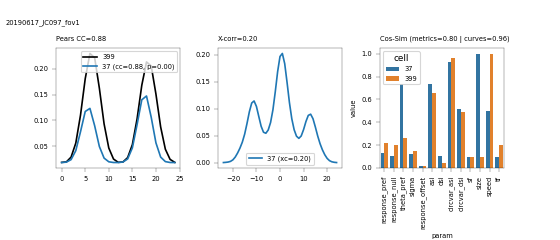

Text(0.01, 0.9, '20190617_JC097_fov1')

In [122]:
%matplotlib notebook
#r1 =27
# r2 = 116
#r2 = 281

popt_r1 = fitdf[params].loc[r1]
fitr1 = osi.double_gaussian(thetas, *popt_r1)

fig, axn = pl.subplots(1,3, figsize=(7,3))
ax=axn[0]
ax.plot(fitr1, label=r1, color='k')

for r2 in [ r2]: #[37, 361, 203]:
    popt_r2 = fitdf[params].loc[r2]
    fitr2 = osi.double_gaussian(thetas, *popt_r2)

    ccorr = signal.correlate(fitr1, fitr2)
    lags = signal.correlation_lags(len(fitr1), len(fitr2))
    cc, pv = spstats.pearsonr(fitr1, fitr2)
    
    axn[0].plot(fitr2, label='%i (cc=%.2f, p=%.2f)' % (r2, cc, pv))
    axn[0].set_title('Pears CC=%.2f' % cc, loc='left', fontsize=6)

    #ax.legend()
    lagzero = list(lags).index(0)
    xcorr = ccorr[lagzero]

    axn[1].plot(lags, ccorr, label='%i (xc=%.2f)' % (r2, xcorr))
    axn[1].set_title('X-corr=%.2f' % xcorr, loc='left', fontsize=6)
    #axn[1].set_ylim([0, 1])

axn[0].legend()
axn[1].legend()

ax=axn[2]
cosim_c = cosine_similarity(fitr1, fitr2)
d0, cosim_m = get_paired_tuning_metrics(fitdf, r1, r2)
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)
ax.set_title('Cos-Sim (metrics=%.2f | curves=%.2f)' % (cosim_m, cosim_c), 
            loc='left', fontsize=6)

pl.subplots_adjust(left=0.1, right=0.9, bottom=0.3, wspace=0.3, top=0.8)

fig.text(0.01, 0.9, dk)

In [25]:
cosine_similarity(fitr1, fitr2)

0.9261705840406864

In [116]:
def get_paired_tuning_metrics(fitdf, r1, r2):
    tuning_params = ['response_pref', 'response_null', 'theta_pref', 'sigma',
                     'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 
                     'sf', 'size', 'speed', 'tf']
    d_=[]
    for ri in [r1, r2]:
        d1 = pd.DataFrame({'param': fitdf.loc[ri][tuning_params].index.tolist(),
                            'value': fitdf.loc[ri][tuning_params].values})
        d1['cell'] = ri
        d_.append(d1)
    d0 = pd.concat(d_, axis=0)
    cosim_m1 = cosine_similarity(d0[d0['cell']==r1]['value'].values, 
                                d0[d0['cell']==r2]['value'].values)
    # normalize values
    d0.loc[d0.param=='size', 'value'] = d0[d0.param=='size']['value'] /200. 
    d0.loc[d0.param=='speed', 'value'] = d0[d0.param=='speed']['value'] /20. 
    d0.loc[d0.param=='theta_pref', 'value'] = d0[d0.param=='theta_pref']['value'] /360. 
    d0.loc[d0.param=='sigma', 'value'] = d0[d0.param=='sigma']['value'] /180. 
    d0.loc[d0.param=='tf', 'value'] = d0[d0.param=='tf']['value'] /10. 

    cosim_m = cosine_similarity(d0[d0['cell']==r1]['value'].values, 
                                d0[d0['cell']==r2]['value'].values)
    return d0, cosim_m
    #print(cosim_m1, cosim_m)

In [102]:
get_paired_tuning_metrics(fitdf, r1, r2)

0.9857650412181227 0.8582520592249347


In [84]:
fitdf.loc[r1][tuning_params].index

Index(['response_pref', 'response_null', 'theta_pref', 'sigma',
       'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'sf',
       'size', 'speed', 'tf'],
      dtype='object')

<IPython.core.display.Javascript object>


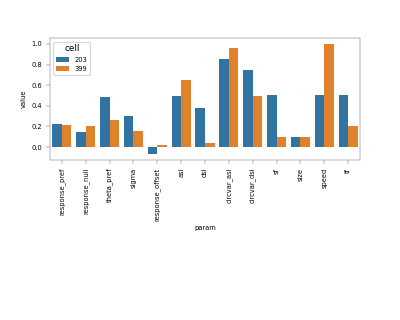

In [95]:
fig, ax = pl.subplots()
sns.barplot(x='param', y='value', hue='cell', data=d0, ax=ax,
           dodge=True)
ax.tick_params(axis='x', rotation=90)
pl.subplots_adjust(bottom=0.5)

In [56]:
cosine_similarity(fitdf.loc[r1][tuning_params], fitdf.loc[r2][tuning_params])


0.9541915669366513

## debug fits

In [113]:
pars = ['gof','sigma', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'sf', 'size', 'speed']

gdata[(gdata.datakey==dk) & (gdata['cell']==107)][pars]

,gof,sigma,asi,dsi,circvar_asi,circvar_dsi,sf,size,speed
2567,0.612545,23.429372,0.723484,0.21754,0.896353,0.690266,0.1,200.0,20.0


In [115]:
fitres, fitparams = gutils.load_tuning_results(dk, fit_desc=ori_fit_desc)


In [118]:
rid = 107
fitres[rid]

{(0.1,
  20.0,
  20): {'results':      response_pref  response_null  theta_pref      sigma  response_offset  \
  0         0.319591       0.224039  275.030744  22.500000         0.250420   
  1         0.251892       0.214297  102.173855  31.469004         0.209163   
  2         0.252955       0.234488   97.092914  26.704377         0.247924   
  3         0.278421       0.165424  104.683387  35.264606         0.197618   
  4         0.261811       0.218827  275.411303  22.500000         0.256697   
  ..             ...            ...         ...        ...              ...   
  495       0.316770       0.251721  110.284715  48.225670         0.055361   
  496       0.229872       0.227676  277.341329  22.500000         0.240974   
  497       0.412286       0.231973  101.613582  51.640699         0.076976   
  498       0.290760       0.252948  273.011817  22.500000         0.228227   
  499       0.235201       0.203375   93.805015  22.590270         0.221040   
  
            asi  

In [121]:
fitres[rid].keys()

dict_keys([(0.1, 20.0, 20), (0.1, 40.0, 20), (0.1, 200.0, 20), (0.5, 20.0, 20), (0.5, 200.0, 20)])

In [122]:
rmetrics, rmetrics_all_cfgs = gutils.get_good_fits(fitres, fitparams, gof_thr=None)


... 97 (of 103) fitable cells (no GoF thr)


In [124]:
rmetrics_all_cfgs[rmetrics_all_cfgs['cell']==rid]

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,cell,r2comb,gof,sf,size,speed
sf-0.10-sz-200-sp-20,0.504464,0.318016,271.836735,23.429372,0.145669,0.723484,0.21754,0.896353,0.690266,0.904699,107,0.534968,0.612545,0.1,200.0,20.0


In [125]:
for stimparam, bootr in fitres[rid].items():
    #r2comb, gof, fitr = gutils.evaluate_fits(bootr, interp=3)
    #print(stimparam, gof)

(0.1, 20.0, 20) nan
(0.1, 40.0, 20) nan
(0.1, 200.0, 20) 0.6125448933397163
(0.5, 20.0, 20) nan
(0.5, 200.0, 20) nan


In [130]:
eparams = [c for c in bootr['results'].columns if 'stim' not in c]
print(eparams)


['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset', 'asi', 'dsi', 'circvar_asi', 'circvar_dsi', 'r2', 'cell']


In [152]:
fit_params= ['response_pref', 'response_null', 'theta_pref', 'sigma', 'response_offset']
             
for stimparam, bootr in fitres[rid].items():
    
    fitdf = bootr['results'][eparams]
#     for param in fitdf.columns:
#         if 'theta' in param:
#             cnts, bns = np.histogram(fitdf[param] % 360., bins=np.linspace(0, 360., 50)) 
#             meanval = float(bns[np.where(cnts==max(cnts))[0][0]])  
#         else:
#             meanval = fitdf[param].mean()
#         print(param, meanval)
    avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
    #print(stimparam, avg_metrics)
    orig_ = bootr['data']['responses'].mean(axis=0).copy()
    if orig_.min()<0:
        print(stimparam, 'neg.')
        orig_ -= orig_.min()
    origr = gutils.interp_values(orig_)   
    thetas = bootr['fits']['xv']
    cpopt = tuple(avg_metrics[fit_params].values[0])
    fitr = gutils.double_gaussian( thetas, *cpopt) 
    r2_comb, _ = gutils.coeff_determination(origr, fitr)
    iqr = spstats.iqr(bootr['results']['r2'])          
    gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb) 
    print(stimparam, gfit)

0.1968532985056689
(0.1, 20.0, 20) 0.4967150432314194
0.09582170304881409
(0.1, 40.0, 20) 0.836783415282605
0.09684316594010572
(0.1, 200.0, 20) 0.8047953761626189
0.3399764977173693
(0.5, 20.0, 20) nan
0.14527391384274382
(0.5, 200.0, 20) 0.270802526259742


In [160]:
stimparam = (0.5, 20.0, 20)
bootr = fitres[rid][stimparam]
avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
orig_ = bootr['data']['responses'].mean(axis=0).copy()
origr = gutils.interp_values(orig_)   
thetas = bootr['fits']['xv']
cpopt = tuple(avg_metrics[fit_params].values[0])
fitr = gutils.double_gaussian( thetas, *cpopt) 
r2_comb, _ = gutils.coeff_determination(origr, fitr)

In [162]:
iqr = spstats.iqr(bootr['results']['r2'])          
gfit = np.mean(bootr['results']['r2']) * (1-iqr) * np.sqrt(r2_comb) 

In [165]:
np.mean(bootr['results']['r2'])

0.8003723260982941

In [166]:
(1-iqr)

0.8565975455384629

In [169]:
dk

'20190511_JC083_fov1'

<IPython.core.display.Javascript object>


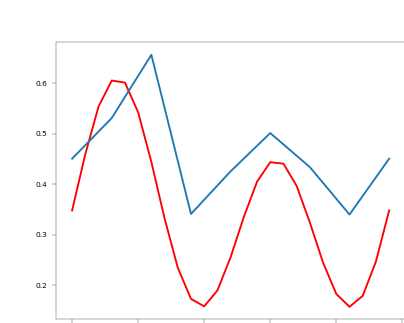

In [161]:
fig, ax = pl.subplots()
ax.plot(fitr, 'r')
ax.plot(origr)

In [151]:
bootr['data']['responses'].mean(axis=0).min()

0.14527391384274382

In [136]:
cnts, bns = np.histogram(fitdf[param] % 360., bins=np.linspace(0, 360., 50)) 
float(bns[np.where(cnts==max(cnts))[0][0]])  

249.79591836734696

In [139]:
avg_metrics = gutils.average_metrics_across_iters(bootr['results'][eparams])
avg_metrics

,response_pref,response_null,theta_pref,sigma,response_offset,asi,dsi,circvar_asi,circvar_dsi,r2,cell
107,0.251711,0.134647,249.795918,58.8425,0.016991,0.348899,0.604985,0.873725,0.944883,0.77321,107.0


# Calcualte point differences

In [63]:
angdists = cr.aggregate_angular_dists(FITS, min_ncells=5)

too few cells: Li, 20190314_JC070_fov1
too few cells: Li, 20190315_JC070_fov2
too few cells: Li, 20190321_JC070_fov2
too few cells: Li, 20190522_JC089_fov1
too few cells: Li, 20190617_JC099_fov1
too few cells: Li, 20191105_JC117_fov1
too few cells: Li, 20191111_JC120_fov1
too few cells: Lm, 20191105_JC117_fov1


In [64]:
df = angdists.copy()

<IPython.core.display.Javascript object>


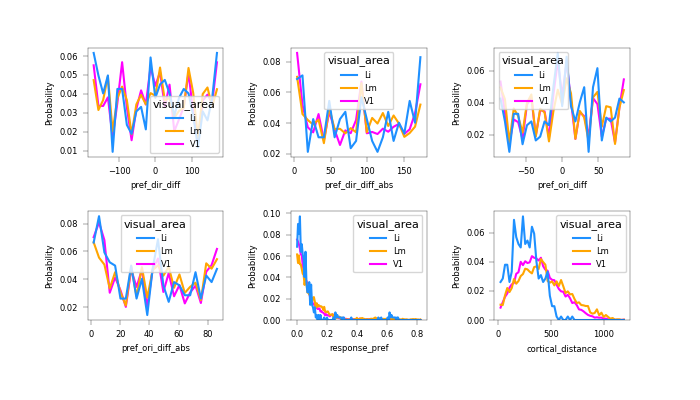

In [65]:
%matplotlib notebook
# plotd = angdists.copy()
plotd = df.dropna().copy()
plot_list = ['pref_dir_diff', 'pref_dir_diff_abs', 
             'pref_ori_diff', 'pref_ori_diff_abs','response_pref',
            'cortical_distance']
fig, axn =pl.subplots(2, int(len(plot_list)/2), figsize=(7,4))
for ax, par in zip(axn.flat, plot_list):
    sns.histplot(x=par, data=plotd, ax=ax, common_norm=False,
            hue='visual_area', palette=area_colors, stat='probability',
            element='poly', fill=False)
pl.subplots_adjust(bottom=0.2, wspace=0.5, hspace=0.5)

In [59]:
np.arange(0, )

array([], dtype=int64)

In [67]:
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

<IPython.core.display.Javascript object>


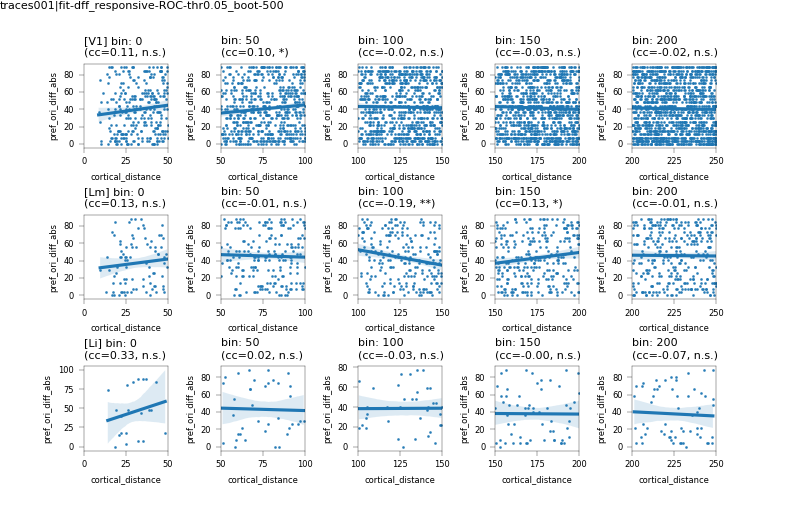

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs_v_binCTX_50um


In [80]:
%matplotlib notebook
y_var='pref_ori_diff_abs'
dist_var = 'cortical_distance'
scatter_kws={'s': 1}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,5.3))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([ctx_bins[di], ctx_bins[di+1]])
        ax.set_xticks(np.linspace(ctx_bins[di], ctx_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_binCTX_%ium' % (y_var, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

## Compare with signal corrs

In [81]:
SDF = aggr.check_sdfs(NDATA['datakey'].unique(), experiment=experiment,
                      images_only=False,rename=False, 
                      return_incorrect=False, return_all=False)
select_stimuli='fullfield'
distance_var = 'rf_distance'
min_ncells=10
CORRS = cr.aggregate_ccdist(NDATA, experiment=experiment, rfdf=None,
                        SDF=SDF, select_stimuli=select_stimuli,min_ncells=min_ncells,
                        distance_var=distance_var, verbose=True)

Checking gratings configs
Dist: cortical_distance
Skipping - (Li, 20190321_JC070_fov2)
Skipping - (Li, 20191105_JC117_fov1)
Skipping - (Lm, 20191105_JC117_fov1)
8 datasets w wrong configs:
    ('Li', '20190314_JC070_fov1')
    ('Li', '20190315_JC070_fov2')
    ('Li', '20190522_JC089_fov1')
    ('Lm', '20190306_JC061_fov2')
    ('Lm', '20190512_JC083_fov1')
    ('Lm', '20190513_JC078_fov1')
    ('V1', '20190511_JC083_fov1')
    ('V1', '20190512_JC083_fov1')
0 datasets w/out RF fits:


In [83]:
ign_cols =  ['experiment', 'signal_cc', 'noise_cc', 'n_cells']
cc_cols = [k for k in CORRS.columns if k not in ign_cols]
# DF = pd.merge(angdists, ccdf, on=cc_cols, how='inner')
ccdf = pd.merge(angdists, CORRS, on=cc_cols, how='inner')

In [ ]:
# 

In [91]:
df = ccdf.copy()

In [92]:
# Split distances into X um bins
ctx_step=50
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')

In [86]:
angdists.shape

(19409, 13)

<IPython.core.display.Javascript object>


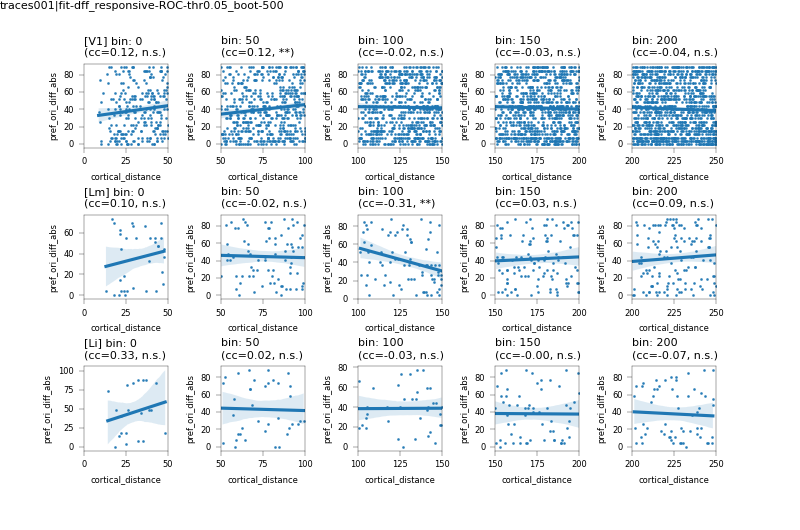

/n/coxfs01/julianarhee/aggregate-visual-areas/correlations/gratings_dff_ROC/pref_theta pref_ori_diff_abs_v_binCTX_50um_cc


In [93]:
%matplotlib notebook
y_var='pref_ori_diff_abs'
dist_var = 'cortical_distance'
scatter_kws={'s': 1}
n_bins_plot = 5
# --------------------------------------------------------------
# plot
fig, axn = pl.subplots(3, n_bins_plot, figsize=(8,5.3))
for va, vg in df.groupby('visual_area'):
    vi = visual_areas.index(va)
    for di, (dist_bin, dg) in enumerate(vg.groupby('%s_label' % dist_var)):
        if di >= n_bins_plot:
            continue
        ax = axn[vi, di]
        ax.set_xlim([ctx_bins[di], ctx_bins[di+1]])
        ax.set_xticks(np.linspace(ctx_bins[di], ctx_bins[di+1], 3))
        g0 = sns.regplot(data=dg, ax=ax, scatter=True,
                    x=dist_var, y=y_var, scatter_kws=scatter_kws)
        cc, pv = spstats.spearmanr(dg[dist_var].values, dg[y_var].values)
        if pv<0.05:
            sig_str = '**' if pv<0.01 else '*'
        else:
            sig_str = 'n.s.'
        vstr='[%s] ' % va if di==0 else ''
        ax.set_title("%sbin: %i\n(cc=%.2f, %s)" % (vstr,dist_bin, cc, sig_str), 
                     loc='left')
for ax in axn.flat:
    ax.set_box_aspect(1)
pl.subplots_adjust(left=0.1, right=0.9, bottom=0.15, wspace=0.5, hspace=0.8)
pplot.label_figure(fig, data_id)

figname = '%s_v_binCTX_%ium_cc' % (y_var, ctx_step)
pl.savefig(os.path.join(dst_dir, '%s.svg' % figname))
print(dst_dir, figname)

In [119]:
df = ccdf.copy()
# --------------------------------------------------
metric = 'pref_ori_diff_abs'
m_bins = np.linspace(0, 90, 9)
df = cr.cut_bins(df, m_bins, metric=metric)

ctx_step=12.5
ctx_bins = np.arange(0, 1200+ctx_step, ctx_step)
df = cr.cut_bins(df, ctx_bins, 'cortical_distance')